In [9]:
# Import libraries
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [10]:
# Set seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)

In [11]:
# Path to dataset (change accordingly)
DATA_DIR = "../datasets/archive/HAM10000_images"  # Put all images (part1 + part2) here
CSV_PATH = "../datasets/archive/HAM10000_metadata.csv"


In [12]:
# Load metadata CSV
meta = pd.read_csv(CSV_PATH)

In [13]:
# Map lesion dx to binary cancer label
cancer_labels = ["mel", "bcc", "akiec"]  # Malignant / pre-cancer
meta["is_cancer"] = meta["dx"].apply(lambda x: 1 if x in cancer_labels else 0)

In [14]:
# Prepare image paths and labels
image_paths = []
labels = []
for idx, row in meta.iterrows():
    image_id = row["image_id"]
    label = row["is_cancer"]
    img_path = os.path.join(DATA_DIR, image_id + ".jpg")
    if os.path.exists(img_path):
        image_paths.append(img_path)
        labels.append(label)

print(f"Total images found: {len(image_paths)}")
print(f"Positive cancer cases: {sum(labels)}")
print(f"Negative cases: {len(labels) - sum(labels)}")

Total images found: 10015
Positive cancer cases: 1954
Negative cases: 8061


In [15]:
# Train-validation split (80% train, 20% val)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)

print(f"Train samples: {len(train_paths)}, Validation samples: {len(val_paths)}")

Train samples: 8012, Validation samples: 2003


In [16]:
# Parameters
BATCH_SIZE = 32
IMG_SIZE = 224  # Image size to resize

In [17]:
# Dataset preprocessing functions
def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG as RGB
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])  # Resize to IMG_SIZE
    img = img / 255.0  # Normalize to [0,1]
    return img, label

def prepare_dataset(paths, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED)
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


In [18]:
# Prepare train and validation datasets
train_ds = prepare_dataset(train_paths, train_labels, shuffle=True)
val_ds = prepare_dataset(val_paths, val_labels, shuffle=False)

In [19]:
# Build a simple CNN model
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 307ms/step - accuracy: 0.7852 - loss: 0.5167 - precision: 0.1913 - recall: 0.0506 - val_accuracy: 0.8048 - val_loss: 0.4551 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 306ms/step - accuracy: 0.8003 - loss: 0.4363 - precision: 0.4740 - recall: 0.0062 - val_accuracy: 0.8043 - val_loss: 0.4401 - val_precision: 0.4000 - val_recall: 0.0051
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 307ms/step - accuracy: 0.8133 - loss: 0.3921 - precision: 0.6014 - recall: 0.0443 - val_accuracy: 0.8048 - val_loss: 0.4149 - val_precision: 0.5000 - val_recall: 0.0026
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 317ms/step - accuracy: 0.8105 - loss: 0.3972 - precision: 0.6340 - recall: 0.0809 - val_accuracy: 0.8103 - val_loss: 0.4075 - val_precision: 0.6571 - val_recall: 0.0588
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 328ms/step - accuracy: 0.8204 - loss: 0.3712 - precision: 0.6201 - recall: 0.2428 - val_accuracy

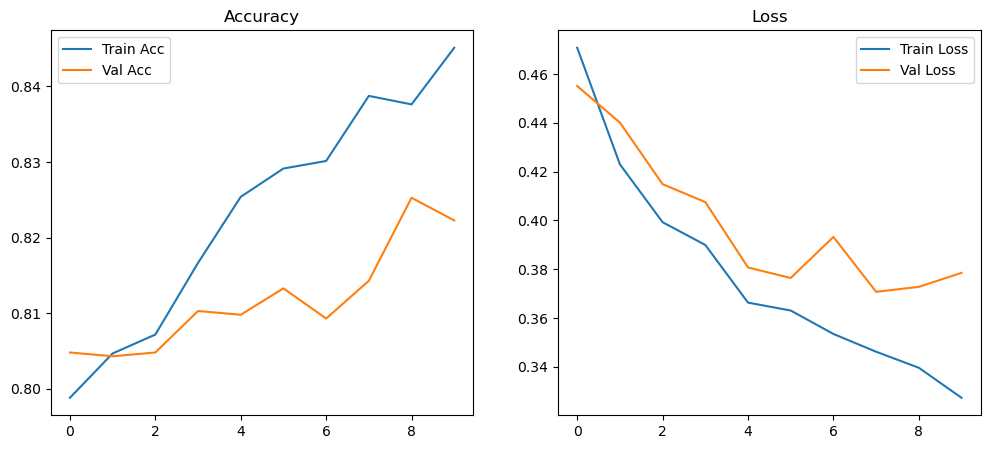

In [22]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [23]:
# Save the model (Keras HDF5 format)
model.save("../ham10000_cancer_classifier.h5")

print("Model saved as ham10000_cancer_classifier.h5")

Model saved as ham10000_cancer_classifier.h5


In [24]:
from tensorflow.keras.models import load_model
model = load_model("../ham10000_cancer_classifier.h5")
print("Model loaded as ham10000_cancer_classifier.h5")

Model loaded as ham10000_cancer_classifier.h5


In [ ]:
#this will not work unless cell with val_ds variabale is run
loss, accuracy, precision, recall = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.8252 - loss: 0.3693 - precision: 0.5346 - recall: 0.3854
Validation Accuracy: 0.82
Precision: 0.56
Recall: 0.41


In [ ]:
#Check on own image 
from tensorflow.keras.preprocessing import image

def predict_image(path):
    img = image.load_img(path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_tensor = tf.expand_dims(img_array, axis=0)  # Add batch dimension
    pred = model.predict(img_tensor)
    label = "Cancer" if pred[0][0] > 0.5 else "Benign"
    confidence = pred[0][0]
    print(f"Prediction: {label} (Confidence: {confidence:.2f})")
    plt.imshow(img_array)
    plt.title(f"{label} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

# Usage
predict_image("path_to_own_image.jpg")


CONVERT MODEL .h5  TO .tflite

In [1]:
#Convert .h5 to .tflite
import tensorflow as tf

# Load model
model = tf.keras.models.load_model("../../../ai-microclinic-offline-dataset/HAM10000/ham10000_multiclass_classifier.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open("../../android/app/src/main/assets/ham10000_cancer_classifier.tflite", "wb") as f:
    f.write(tflite_model)

print("Model converted and saved as ham10000_cancer_classifier.tflite")


INFO:tensorflow:Assets written to: C:\Users\karti\AppData\Local\Temp\tmp9k4u2p1w\assets


INFO:tensorflow:Assets written to: C:\Users\karti\AppData\Local\Temp\tmp9k4u2p1w\assets


Saved artifact at 'C:\Users\karti\AppData\Local\Temp\tmp9k4u2p1w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2431774448080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2431774448848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2431774447120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2431774448464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2431774452304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2431774453072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2431774452880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2431774451536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2431774451728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2431774453456: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model co